In [1]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [9]:

import mlflow
import mlflow.sklearn
import mlflow
mlflow.set_experiment("hand_sign_classifier_knn")


2024/12/10 20:02:01 INFO mlflow.tracking.fluent: Experiment with name 'hand_sign_classifier_knn' does not exist. Creating a new experiment.


<Experiment: artifact_location=('/Users/nedday/Documents/All Projects '
 '/hand-sign-images-classification-project/hand-sign-images-classification-project/Knn_WithMlflow/mlruns/206757957583898682'), creation_time=1733857321485, experiment_id='206757957583898682', last_update_time=1733857321485, lifecycle_stage='active', name='hand_sign_classifier_knn', tags={}>

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("furkanakdeniz/asl-handsign-dataset-grayscaled-thresholded")

print("Path to dataset files:", path)

Path to dataset files: /Users/nedday/.cache/kagglehub/datasets/furkanakdeniz/asl-handsign-dataset-grayscaled-thresholded/versions/1


In [ ]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib
import matplotlib.pyplot as plt
import cv2  # Pour redimensionner les images

# Chemin vers le dataset
dataset_path = "/Users/nedday/.cache/kagglehub/datasets/furkanakdeniz/asl-handsign-dataset-grayscaled-thresholded/versions/1/asl-dataset/asl-dataset"
# Alphabets disponibles dans le dataset
alphabet_array = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

# Charger les images et leurs étiquettes
image_arr = []
image_name_value = []

# Taille cible pour toutes les images
target_size = (28, 28)

for letter in alphabet_array:
    path_letter = os.path.join(dataset_path, "train", letter)
    if not os.path.exists(path_letter):
        print(f"Le dossier {path_letter} n'existe pas.")
        continue

    for image_name in os.listdir(path_letter):
        image_path = os.path.join(path_letter, image_name)
        # Charger et redimensionner l'image
        image = plt.imread(image_path)  # Charger l'image
        if image.ndim == 3:  # Convertir en niveau de gris si l'image est RGB
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        resized_image = cv2.resize(image, target_size)  # Redimensionner
        image_arr.append(resized_image.flatten())  # Aplatir et ajouter à la liste
        image_name_value.append(letter)

In [12]:
# Conversion en tableaux numpy
X_data = np.array(image_arr)
y_data = np.array(image_name_value)

# Créer un mapping des étiquettes vers des entiers
label_to_int = {label: idx for idx, label in enumerate(np.unique(y_data))}
y_data = np.array([label_to_int[label] for label in y_data])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score
import joblib
import mlflow
import mlflow.sklearn
import itertools
import time

# Configurer MLflow pour stocker les logs localement
mlflow.set_tracking_uri("mlruns")

# Paramètres à tester dans GridSearch
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Générer toutes les combinaisons possibles de paramètres
param_combinations = list(itertools.product(
    param_grid['n_neighbors'],
    param_grid['weights'],
    param_grid['metric']
))

# Variables pour suivre le meilleur modèle
best_accuracy = 0
best_model = None
best_params = {}
i = 0

# Boucle sur chaque combinaison de paramètres
for params in param_combinations:
    n_neighbors, weights, metric = params
    with mlflow.start_run(run_name=f"Version_{i}") as run:
        # Ajouter un tag avec le numéro de version
        mlflow.set_tag("version", f"Version_{i}")
        mlflow.set_tag("model_type", "KNeighborsClassifier")


        # Entraînement du modèle
        start_time = time.time()
        print(f"Run Version_{i} started with n_neighbors={n_neighbors}, weights={weights}, metric={metric}")
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        execution_time = time.time() - start_time

        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, "KNN")

        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        mlflow.log_params({'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric})
        mlflow.log_metric("test_accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("execution_time", execution_time)

        # Sauvegarder le modèle pour chaque run
        model_filename = f"knn_model_version_{i}.pkl"
        joblib.dump(model, model_filename)
        mlflow.log_artifact(model_filename)

        # Vérifier si ce modèle est le meilleur
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

        print(f"Run Version_{i} completed with accuracy={accuracy:.4f}, precision={precision:.4f}. Execution time: {execution_time:.2f} seconds.")
        i += 1  # Incrémenter la version

# Sauvegarder le meilleur modèle
#best_model_filename = "knn_best_model.pkl"
#joblib.dump(best_model, best_model_filename)
#print(f"Meilleur modèle sauvegardé sous : {best_model_filename}")

# Télécharger le répertoire MLflow pour une visualisation locale
#print("Compression des logs MLflow...")
#!zip -r mlruns.zip /content/mlruns


Run Version_0 started with n_neighbors=3, weights=uniform, metric=euclidean


2024/12/10 20:02:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_0 completed with accuracy=0.9874, precision=0.9876. Execution time: 2.09 seconds.
Run Version_1 started with n_neighbors=3, weights=uniform, metric=manhattan


2024/12/10 20:03:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_1 completed with accuracy=0.9837, precision=0.9840. Execution time: 54.19 seconds.
Run Version_2 started with n_neighbors=3, weights=distance, metric=euclidean


2024/12/10 20:03:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_2 completed with accuracy=0.9902, precision=0.9903. Execution time: 2.00 seconds.
Run Version_3 started with n_neighbors=3, weights=distance, metric=manhattan


2024/12/10 20:04:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_3 completed with accuracy=0.9877, precision=0.9879. Execution time: 53.91 seconds.
Run Version_4 started with n_neighbors=5, weights=uniform, metric=euclidean


2024/12/10 20:04:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_4 completed with accuracy=0.9779, precision=0.9784. Execution time: 3.21 seconds.
Run Version_5 started with n_neighbors=5, weights=uniform, metric=manhattan


2024/12/10 20:05:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_5 completed with accuracy=0.9729, precision=0.9737. Execution time: 54.57 seconds.
Run Version_6 started with n_neighbors=5, weights=distance, metric=euclidean


2024/12/10 20:05:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_6 completed with accuracy=0.9844, precision=0.9847. Execution time: 3.15 seconds.
Run Version_7 started with n_neighbors=5, weights=distance, metric=manhattan


2024/12/10 20:06:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_7 completed with accuracy=0.9817, precision=0.9822. Execution time: 55.18 seconds.
Run Version_8 started with n_neighbors=7, weights=uniform, metric=euclidean


2024/12/10 20:06:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_8 completed with accuracy=0.9692, precision=0.9703. Execution time: 3.30 seconds.
Run Version_9 started with n_neighbors=7, weights=uniform, metric=manhattan


2024/12/10 20:07:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_9 completed with accuracy=0.9649, precision=0.9662. Execution time: 55.14 seconds.
Run Version_10 started with n_neighbors=7, weights=distance, metric=euclidean


2024/12/10 20:07:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_10 completed with accuracy=0.9784, precision=0.9789. Execution time: 3.29 seconds.
Run Version_11 started with n_neighbors=7, weights=distance, metric=manhattan


2024/12/10 20:08:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run Version_11 completed with accuracy=0.9765, precision=0.9772. Execution time: 55.55 seconds.


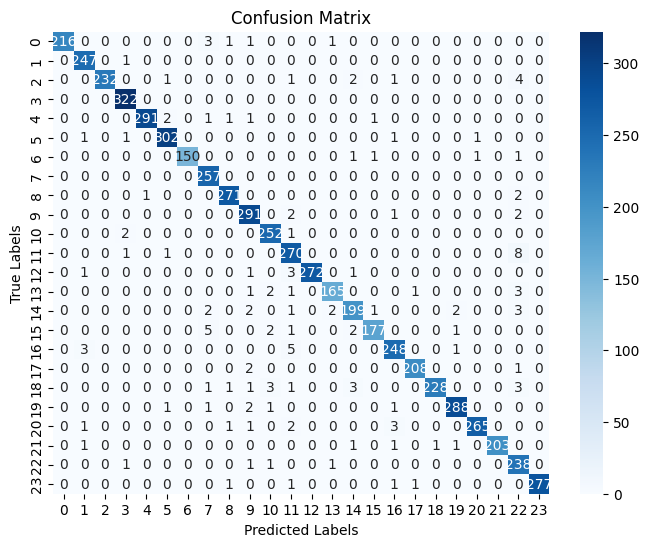

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f"Confusion Matrix")
plt.show()


## Manage model versions

In [15]:
import mlflow
from mlflow.tracking import MlflowClient

# Nom unique pour le modèle dans le registre
model_name = "KNN_Model"

# Enregistrement du meilleur modèle
mlflow.set_tracking_uri("mlruns")
client = MlflowClient()

# Démarrer une nouvelle session MLflow pour le meilleur modèle
with mlflow.start_run(run_name="Best_Model_Registration") as run:
    # Loguer le meilleur modèle dans cette nouvelle session
    mlflow.sklearn.log_model(best_model, "best_knn_model")

    # Enregistrement dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/best_knn_model"
    registered_model = mlflow.register_model(model_uri, model_name)

    # Ajouter une description au modèle
    client.update_registered_model(
        name=model_name,
        description="KNN Classifier trained on hand sign dataset with optimized hyperparameters.",
    )

    # Ajouter une version et un tag
    client.transition_model_version_stage(
        name=model_name,
        version=registered_model.version,
        stage="Production",  # ou "Staging" si besoin
    )

    print(f"Le modèle est enregistré sous le nom '{model_name}' avec la version {registered_model.version}.")


2024/12/09 22:46:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le modèle est enregistré sous le nom 'KNN_Model' avec la version 1.


Successfully registered model 'KNN_Model'.
Created version '1' of model 'KNN_Model'.
/var/folders/zk/pf_lp1yn7wd1lbr8mwy593rc0000gn/T/ipykernel_23631/2568249302.py:27: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [ ]:
import requests
import json

# Fonction pour convertir un numéro en lettre de l'alphabet
def number_to_letter(number):
    # Vérifier que le nombre est dans la plage de 1 à 24 (pour les lettres de A à Z)
    if 1 <= number <= 24:
        return chr(64 + number)  # 'A' est le caractère ASCII 65, donc 64 + number donne la lettre
    else:
        return None  # Gérer les cas où le numéro dépasse 24

# Supposons que 'X_test' contient des images
sample_image = X_test[0]  # Sélection de la première image

# Convertir l'image en liste pour la sérialisation JSON
input_data = {
    "inputs": [sample_image.tolist()]  # Ajouter des crochets pour obtenir un tableau 4D
}

url = "http://127.0.0.1:8989/invocations"  

# Envoi de la requête POST
headers = {"Content-Type": "application/json"}
response = requests.post(url, headers=headers, data=json.dumps(input_data))

# Affichage du résultat de la prédiction
if response.status_code == 200:
    prediction = response.json()
    predicted_number = prediction['predictions'][0]  # Récupérer le premier élément de la prédiction
    predicted_letter = number_to_letter(predicted_number)  # Convertir en lettre
    print("Prédiction (lettre) :", predicted_letter)
else:
    print("Erreur :", response.status_code, response.text)


Prédiction (lettre) : V
